In [1]:
import pandas as pd
import numpy as np

# 读取文件, 生成DataFrame

In [144]:
# use the first line of file as columns names, if no columns names in the file, use "header=None"
train = pd.read_csv("train.csv", header=[0])

test = pd.read_csv("test.csv", header=[0])

In [2]:
# 读取文件指定header, 指定delimiter
cols = ['user','item','rating','timestamp']

train = pd.read_csv('ua.base',delimiter='\t',names = cols)
train.head()

,user,item,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


# 查看一下数据结构

## 查看各个feature取值的集合的大小

In [145]:
train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

## 分析某个feature的各个取值比例

<AxesSubplot:>

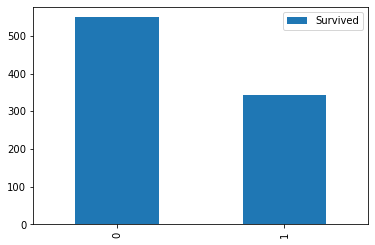

In [146]:
pd.DataFrame(train.Survived.value_counts()).plot(kind="bar")

# EDA

## 查看各个特征之间的关系

In [147]:
# 查看 性别Sex 对 存活Survived 的影响
pd.DataFrame(train.groupby("Sex")["Survived"].value_counts(normalize=True)*100) # 转化成DataFrame是为了好观察

Survived
Sex    Survived           
female 1         74.203822
       0         25.796178
male   0         81.109185
       1         18.890815

In [148]:
# 查看 性别Sex 和 存活Survived 的交叉表
pd.crosstab(train.Sex, train.Survived)

Survived,0,1
Sex,,
female,81,233
male,468,109


<AxesSubplot:xlabel='Sex'>

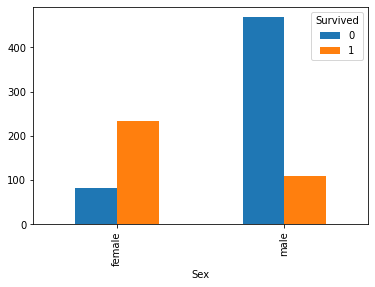

In [149]:
pd.crosstab(train.Sex, train.Survived).plot(kind="bar")
# 明显可以看出, 男性的死亡率高.

# 特征工程

## 查看各个feature的空值情况

In [150]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 填充空缺值

### 对一列的空值填充:固定值

In [151]:
train.Embarked.fillna("S", inplace=True)

### 对一列的空值填充:中位数

In [152]:
# 车票跟船舱等级Pclass & 出发地Embarked 有关系
test_empty_fare = test[test.Fare.isna()]

# bool索引 & 使用中位数median进行填充
median = test[(test.Embarked=="S") & (test.Pclass==3)].Fare.median()

# 填充                                
test.Fare.fillna(median, inplace=True)

### 针对每行数据, 进行不同的空值填充

#### 数据分桶(船票价格)

In [153]:
# 根据排序 或 基于样本分位数 将变量 分到大小相等的桶中。
# pandas.qcut(x, q, labels=None) 
train_fare_grp = pd.qcut(train.Fare, 4, labels=['Economy','Economy Plus','Business','First'])
train_fare_grp

0           Economy
1             First
2      Economy Plus
3             First
4      Economy Plus
           ...     
886    Economy Plus
887        Business
888        Business
889        Business
890         Economy
Name: Fare, Length: 891, dtype: category
Categories (4, object): ['Economy' < 'Economy Plus' < 'Business' < 'First']

In [154]:
## 增加一列数据
train['Fare_Grp'] = train_fare_grp
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_Grp
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Economy
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,First
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Economy Plus
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,First
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Economy Plus


#### 根据"船票的等级Fare_Grp" 和 "船舱等级 Pclass" 对 "Cabin"进行填充

In [157]:
def fill_cabin(df):
    # 遍历df的所有行
    for i in range(len(df)):
        # 找到cabin为空的行
        if (df.Cabin.isna()[i]):
            # 获取该行样本的 Pclass 和 Fare_Grp
            pclass = df.iloc[i, :]["Pclass"]
            fare_grp = df.iloc[i, :]["Fare_Grp"]
            # 取满足pclass or fare_grp相等的所有样本的cabin众数.
            cabin_mode = df[(df['Pclass'] == pclass) | (df['Fare_Grp'] == fare_grp)].Cabin.mode().values[0] # 众数可能不止一个, 取第一个
            # 填充cabin空值
            df["Cabin"].iloc[i] = cabin_mode # OK 先取列, 再取行
            # df.iloc[i]["Cabin"] = cabin_mode # not work

train.isna().sum()
fill_cabin(train)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

## 对一个column的内容进行mapper替换

In [163]:
# 替换DataFrame/Series的值
# DataFrame/Series.replace(to_replace=None, value=None, inplace=False)

# 两个list长度要相等, 一一对应替换
train.Name.replace(["Mr.", "Mrs."], ["MR.", "MRS."], inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_Grp
0,1,0,3,"Braund, MR. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,G6,S,Economy
1,2,1,1,"Cumings, MR.. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,First
2,3,1,3,"Heikkinen, MR. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,G6,S,Economy Plus
3,4,1,1,"Futrelle, MR.. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,First
4,5,0,3,"Allen, MR. William Henry",male,35.0,0,0,373450,8.0500,G6,S,Economy Plus


## 拼接train和test数据集

In [169]:
tmp_test = pd.DataFrame(np.random.randint(0,5,size=(2,3)), columns=["first", "second", "third"])
tmp_train = pd.DataFrame(np.random.randint(6,10,size=(3,3)), columns=["first", "second", "third"])


data = pd.concat([tmp_test, tmp_train], axis=0, ignore_index=True)

## one-hot编码

In [173]:
data["label"] = ["A", "B", "A", "B", "A"]
# DataFrame不会对整数进行one-hot编码, 但是Series会.
pd.get_dummies(data, drop_first=True)

,first,second,third,label_B
0,0,1,3,0
1,1,4,3,1
2,6,6,8,0
3,7,9,8,1
4,9,6,6,0
